In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
%%capture
! unzip /content/gdrive/MyDrive/ecbm4040-assignment-2-task-5.zip

In [3]:
#Generate dataset
import os
import pandas as pd
import numpy as np
from PIL import Image


#Load Training images and labels

train_directory = "/content/kaggle_train_128/train_128"

image_list=[]
label_list=[]
for sub_dir in os.listdir(train_directory):
    print("Reading folder {}".format(sub_dir))
    sub_dir_name=os.path.join(train_directory,sub_dir)
    for file in os.listdir(sub_dir_name):
        filename = os.fsdecode(file)
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_list.append(np.array(Image.open(os.path.join(sub_dir_name,file))))
            label_list.append(int(sub_dir))
X_train=np.array(image_list)
y_train=np.array(label_list)
#Load Test images

test_directory = "/content/kaggle_test_128/test_128"
test_image_list=[]
test_df = pd.DataFrame([], columns=['Id', 'X'])
print("Reading Test Images")
for file in os.listdir(test_directory):
    filename = os.fsdecode(file)
    if filename.endswith(".jpg") or filename.endswith(".png"):
        test_df = test_df.append({
            'Id': filename,
            'X': np.array(Image.open(os.path.join(test_directory,file)))
        }, ignore_index=True)
        
test_df['s'] = [int(x.split('.')[0]) for x in test_df['Id']]
test_df = test_df.sort_values(by=['s'])
test_df = test_df.drop(columns=['s'])
X_test = np.stack(test_df['X'])


print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)

Reading folder 4
Reading folder 1
Reading folder 3
Reading folder 0
Reading folder 2
Reading Test Images
Training data shape:  (15000, 128, 128, 3)
Training labels shape:  (15000,)
Test data shape:  (3500, 128, 128, 3)


In [4]:
#Additional Imports
import time
import tensorflow as tf
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.applications.mobilenet import MobileNet
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import  GlobalAveragePooling2D
from keras.utils import np_utils
from keras.callbacks import Callback,ModelCheckpoint,LambdaCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    zoom_range=0.1, 
    width_shift_range=0.2,
    height_shift_range=0.2, 
    horizontal_flip=True, 
    vertical_flip=False, 
) 
TRAIN_DIR='/content/kaggle_train_128/train_128'
TEST_DIR='/content/kaggle_test_128/test_128'
BATCH_SIZE=32
IMG_HEIGHT=128
IMG_WIDTH=128

for i in os.listdir('/content/kaggle_train_128/train_128'):
    print(str(i)+" "+str(len(os.listdir(os.path.join(TRAIN_DIR+'/'+str(i))))))
print("Test"+" "+str(len(os.listdir(TEST_DIR))))

4 3000
1 3000
3 3000
0 3000
2 3000
Test 3500


Found 12000 images belonging to 5 classes.
Found 3000 images belonging to 5 classes.


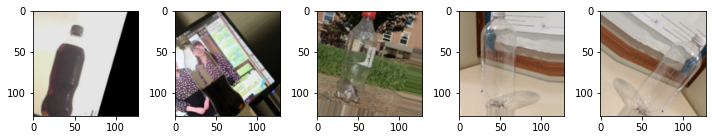

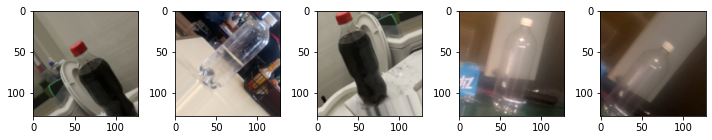

In [6]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show();
image_generator = ImageDataGenerator(rescale=1./255,
                                     validation_split=0.2,
                                     rotation_range = 45,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     brightness_range=[0.76,1.1],
                                     fill_mode = 'nearest',
                                     horizontal_flip = True)
train_data_gen = image_generator.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=TRAIN_DIR,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    subset="training",
    class_mode="categorical"
)
val_data_gen = image_generator.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=TRAIN_DIR,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    subset="validation",
    class_mode="categorical"
)
from random import randrange
augmented_images = [train_data_gen[randrange(5)][0][0] for i in range(5)]
plotImages(augmented_images)
augmented_images = [val_data_gen[randrange(5)][0][0] for i in range(5)]
plotImages(augmented_images)

In [7]:
Train_Samples=12000
Val_Samples=3000
nb_classes=5
MobileNet_model = MobileNet(weights='imagenet', 
                  include_top=False, 
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
MobileNet_model.trainable=False
x = MobileNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
model = Model(inputs = MobileNet_model.input, outputs = predictions)
red_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',patience=3, verbose=1,
    factor=0.5, min_lr=1e-7)
es=EarlyStopping(patience=6,verbose =1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, mode='min', patience=4,verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model_mobile_new_2.h5', save_best_only=True, monitor='val_accuracy', mode='max')
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,decay=0.01), loss = 'categorical_crossentropy',metrics = ['accuracy'])
#model.compile(optimizer = op, loss = 'categorical_crossentropy',metrics = ['accuracy'])

17235968/17225924 [==============================] - 0s 0us/step


In [8]:
now = datetime.datetime.now
t = now()
transfer_learning_history = model.fit(
    train_data_gen,
    steps_per_epoch = train_data_gen.samples // BATCH_SIZE,
    epochs = 10,
    validation_data = val_data_gen,
    # callbacks=[es,checkpoint],
    validation_steps = val_data_gen.samples // BATCH_SIZE,
    verbose=1)
print('Training time: %s' % (now() - t))

Epoch 1/10
375/375 [==============================] - 107s 253ms/step - loss: 1.1191 - accuracy: 0.5403 - val_loss: 0.9932 - val_accuracy: 0.5964
Epoch 2/10
375/375 [==============================] - 94s 252ms/step - loss: 0.8695 - accuracy: 0.6509 - val_loss: 0.9514 - val_accuracy: 0.6129
Epoch 3/10
375/375 [==============================] - 94s 252ms/step - loss: 0.8034 - accuracy: 0.6796 - val_loss: 0.9459 - val_accuracy: 0.6321
Epoch 4/10
375/375 [==============================] - 94s 252ms/step - loss: 0.7588 - accuracy: 0.7002 - val_loss: 0.9163 - val_accuracy: 0.6237
Epoch 5/10
375/375 [==============================] - 94s 252ms/step - loss: 0.7339 - accuracy: 0.7143 - val_loss: 0.9451 - val_accuracy: 0.6190
Epoch 6/10
375/375 [==============================] - 95s 252ms/step - loss: 0.7040 - accuracy: 0.7221 - val_loss: 0.9391 - val_accuracy: 0.6260
Epoch 7/10
375/375 [==============================] - 94s 251ms/step - loss: 0.6954 - accuracy: 0.7275 - val_loss: 0.9114 - val_a

In [9]:
MobileNet_model.trainable=True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)
epochs = 10
model.fit(train_data_gen, epochs=epochs, validation_data=val_data_gen)

Epoch 1/10
375/375 [==============================] - 108s 276ms/step - loss: 0.8781 - categorical_accuracy: 0.6550 - val_loss: 0.9647 - val_categorical_accuracy: 0.6077
Epoch 2/10
375/375 [==============================] - 103s 274ms/step - loss: 0.7241 - categorical_accuracy: 0.7157 - val_loss: 0.8513 - val_categorical_accuracy: 0.6610
Epoch 3/10
375/375 [==============================] - 103s 274ms/step - loss: 0.6351 - categorical_accuracy: 0.7558 - val_loss: 0.7971 - val_categorical_accuracy: 0.6987
Epoch 4/10
375/375 [==============================] - 103s 274ms/step - loss: 0.5883 - categorical_accuracy: 0.7735 - val_loss: 0.7286 - val_categorical_accuracy: 0.7220
Epoch 5/10
375/375 [==============================] - 103s 275ms/step - loss: 0.5293 - categorical_accuracy: 0.7990 - val_loss: 0.6533 - val_categorical_accuracy: 0.7447
Epoch 6/10
375/375 [==============================] - 104s 277ms/step - loss: 0.4912 - categorical_accuracy: 0.8138 - val_loss: 0.6311 - val_categoric

In [11]:
import cv2
import glob
num_images = len(glob.glob("/content/kaggle_test_128/test_128/*.png"))
predict_files = glob.glob("/content/kaggle_test_128/test_128/*.png")
im = cv2.imread(predict_files[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (128, 128)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255
predictor, image_id,probabilities = [], [],[]
for i in predict_files:
    im = cv2.imread(i)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (128, 128)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis = 0)
    prob=model.predict(im)
    probabilities.append(prob)
    outcome = [np.argmax(prob)]
    predictor.extend(list(outcome))
    image_id.extend([i.rsplit("\\")[-1]])
image_name=[]
for i in image_id:
    image_name.append(i.split('/')[-1])
final = pd.DataFrame()
final["Filename"] = image_name
final["Labels"] =  predictor

In [12]:
final

,Filename,Labels
0,1022.png,3
1,2487.png,3
2,340.png,2
3,3221.png,2
4,264.png,1
...,...,...
3495,1413.png,4
3496,1697.png,4
3497,1917.png,1
3498,2616.png,1


In [13]:
final["sorter"] = final.Filename.apply(lambda x: int(x.split(".")[0]))
final = final.sort_values("sorter")
final = final[["Filename","Labels"]]
f = final.rename(columns={"Filename":"Id","Labels":"label"})

In [14]:
f.to_csv("predicted.csv",index=False)